In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import torch.nn.functional as F
from tqdm.notebook import tqdm
from random import shuffle
import torch
from torch import nn, Tensor
import math
from glob import glob
import sys
import shutil  

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


%matplotlib inline

In [ ]:
!pip install --upgrade --no-cache-dir gdown
import gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.4.0
    Uninstalling gdown-4.4.0:
      Successfully uninstalled gdown-4.4.0


In [ ]:
# Download training data
url = "https://drive.google.com/drive/u/0/folders/16ZaNLVBZgn7RYFLiF1jt-WcCF1aRb8aP"
gdown.download_folder(url, quiet=True, use_cookies=False, remaining_ok=True)

['/content/Martian Inverted Channels/Aeolis Dorsa/images/ESP_020673_1750_RED.browse.jpg',
 '/content/Martian Inverted Channels/Aeolis Dorsa/images/ESP_031064_1760_RED.browse.jpg',
 '/content/Martian Inverted Channels/Aeolis Dorsa/images/ESP_035600_1765_RED.browse.jpg',
 '/content/Martian Inverted Channels/Aeolis Dorsa/images/ESP_039385_1760_RED.browse.jpg',
 '/content/Martian Inverted Channels/Aeolis Dorsa/images/ESP_048233_1770_RED.browse.jpg',
 '/content/Martian Inverted Channels/Aeolis Dorsa/images/ESP_053639_1760_RED.browse.jpg',
 '/content/Martian Inverted Channels/Aeolis Dorsa/images/ESP_055195_1735_RED.browse.jpg',
 '/content/Martian Inverted Channels/Aeolis Dorsa/images/ESP_071971_1760_RED.browse.jpg',
 '/content/Martian Inverted Channels/Aeolis Dorsa/images/ESP_072327_1750_RED.browse.jpg',
 '/content/Martian Inverted Channels/Aeolis Dorsa/images/PSP_009623_1755_RED.browse.jpg',
 '/content/Martian Inverted Channels/Aeolis Dorsa/images/PSP_010533_1755_RED.browse.jpg',
 '/content

In [ ]:
# Download test data
url = "https://drive.google.com/drive/u/0/folders/1dGwTm47UJSp0_qLl0n0VCUPMCu56xEZD"
gdown.download_folder(url, quiet=True, use_cookies=False, remaining_ok=True)

['/content/Test data/Aeolis Dorsa/images/ESP_072116_1740_RED.browse.jpg',
 '/content/Test data/Aeolis Dorsa/masks/ESP_072116_1740_RED.browse.png',
 '/content/Test data/Miyamoto Crater/images/ESP_016631_1770_RED.browse.jpg',
 '/content/Test data/Miyamoto Crater/images/ESP_074759_1855_RED.browse.jpg',
 '/content/Test data/Miyamoto Crater/masks/ESP_016631_1770_RED.browse.png',
 '/content/Test data/Miyamoto Crater/masks/ESP_074759_1855_RED.browse.png']

In [ ]:
dirname = './Martian Inverted Channels/'
folders = ["Autocontrast","Brightness","Hflip", "Sharpness", "Vflip"]

for fold in folders:
  if not os.path.exists(dirname+fold+'/images'):
    os.makedirs(dirname+fold+'/images')
  if not os.path.exists(dirname+fold+'/masks'):
    os.makedirs(dirname+fold+'/masks')

In [ ]:
import os
import numpy as np
import torch
import torch.utils.data
import torchvision.transforms as transforms
import torchvision
import PIL
import random
from scipy import ndimage


imageNames = sorted(glob('./Martian Inverted Channels' + '/*/images/*.jpg'))


#Horizontally flipping dataset
for imagePath in imageNames:
  image = cv2.imread(imagePath)
  image = transforms.functional.to_pil_image(image)
  image  = transforms.functional.hflip(image)
  image = np.array(image)
  imgName = imagePath[len(imagePath)-30:-4] 
  cv2.imwrite(dirname+folders[2]+"/images/"+imgName+'.jpg', image)

  mask_path = imagePath.replace('images', 'masks').replace('.jpg', '.png')
  mask = cv2.imread(mask_path)
  mask = transforms.functional.to_pil_image(mask)
  mask  = transforms.functional.hflip(mask)
  mask = np.array(mask)
  cv2.imwrite(dirname+folders[2]+"/masks/"+imgName+'.png', mask)
print("-> Horizontally Flipping completed")

#Vertically flipping dataset
for imagePath in imageNames:
  image = cv2.imread(imagePath)
  image = transforms.functional.to_pil_image(image)
  image  = transforms.functional.vflip(image)
  image = np.array(image)
  imgName = imagePath[len(imagePath)-30:-4] 
  cv2.imwrite(dirname+folders[4]+"/images/"+imgName+'.jpg', image)

  mask_path = imagePath.replace('images', 'masks').replace('.jpg', '.png')
  mask = cv2.imread(mask_path)
  mask = transforms.functional.to_pil_image(mask)
  mask  = transforms.functional.vflip(mask)
  mask = np.array(mask)
  cv2.imwrite(dirname+folders[4]+"/masks/"+imgName+'.png', mask)
print("-> Vertical Flipping completed")

#Adjusting Gaussian Blur
for imagePath in imageNames:
  image = cv2.imread(imagePath)
  image = transforms.functional.to_pil_image(image)
  image  = transforms.functional.gaussian_blur(image,kernel_size=(5, 9), sigma=(0.1, 5))
  image = np.array(image)
  imgName = imagePath[len(imagePath)-30:-4] 
  cv2.imwrite(dirname+folders[2]+"/images/"+imgName+'.jpg', image)

  mask_path = imagePath.replace('images', 'masks').replace('.jpg', '.png')
  mask = cv2.imread(mask_path)
  cv2.imwrite(dirname+folders[2]+"/masks/"+imgName+'.png', mask)
print("-> Gaussian Blur completed")

-> Horizontally Flipping completed
-> Vertical Flipping completed
-> Gaussian Blur completed


In [ ]:
import os
import numpy as np
import torch
import torch.utils.data
import torchvision.transforms as transforms
import PIL
import random
from scipy import ndimage


class segDataset(torch.utils.data.Dataset):
    def __init__(self, root, training, transform=None):
        super(segDataset, self).__init__()
        self.root = root
        self.training = training
        self.transform = transform
        self.IMG_NAMES = sorted(glob(self.root + '/*/images/*.jpg'))
        self.BGR_classes = {'Background' : [ 0, 0, 0],
                            'Inverted Channel' : [ 0, 0, 255]} # in BGR

        self.bin_classes = ['Background', 'Inverted Channel']


    def __getitem__(self, idx):
        
        img_path = self.IMG_NAMES[idx]
        mask_path = img_path.replace('images', 'masks').replace('.jpg', '.png')

        image = cv2.imread(img_path)
        mask = cv2.imread(mask_path)
        plt.imshow(mask)
        cls_mask = np.zeros(mask.shape)

        cls_mask[mask == self.BGR_classes['Background']] = self.bin_classes.index('Background')
        cls_mask[mask == self.BGR_classes['Inverted Channel']] = self.bin_classes.index('Inverted Channel')
        torch.set_printoptions(profile="full")
        #print("class mask",cls_mask)
        cls_mask = cls_mask[:,:,2] #removing nearby elements [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] -> [0,2,4,6,8]
        #print("---------------------------------------------------")
        #print(cls_mask)
        if self.training==True:
            if self.transform:
              image = transforms.functional.to_pil_image(image)
              image = self.transform(image)
              image = np.array(image)

            # 90 degree rotation
            if np.random.rand()<0.5:
              angle = np.random.randint(4) * 90
              image = ndimage.rotate(image,angle,reshape=True)
              cls_mask = ndimage.rotate(cls_mask,angle,reshape=True)

            # vertical flip
            if np.random.rand()<0.5:
              image = np.flip(image, 0)
              cls_mask = np.flip(cls_mask, 0)
            
            # horizonal flip
            if np.random.rand()<0.5:
              image = np.flip(image, 1)
              cls_mask = np.flip(cls_mask, 1)

        # image = cv2.resize(image, (512,512))/255.0
        # cls_mask = cv2.resize(cls_mask, (512,512)) 
        image = cv2.resize(image, (1024,1024))/255.0
        cls_mask = cv2.resize(cls_mask, (1024,1024))
        image = np.moveaxis(image, -1, 0)

        return torch.tensor(image).float(), torch.tensor(cls_mask, dtype=torch.int64)


    def __len__(self):
        return len(self.IMG_NAMES)

In [ ]:
dataset = segDataset('./Martian Inverted Channels', training = True)
print(dataset.IMG_NAMES)

len(dataset)

['./Martian Inverted Channels/Aeolis Dorsa/images/ESP_020673_1750_RED.browse.jpg', './Martian Inverted Channels/Aeolis Dorsa/images/ESP_031064_1760_RED.browse.jpg', './Martian Inverted Channels/Aeolis Dorsa/images/ESP_035600_1765_RED.browse.jpg', './Martian Inverted Channels/Aeolis Dorsa/images/ESP_039385_1760_RED.browse.jpg', './Martian Inverted Channels/Aeolis Dorsa/images/ESP_048233_1770_RED.browse.jpg', './Martian Inverted Channels/Aeolis Dorsa/images/ESP_053639_1760_RED.browse.jpg', './Martian Inverted Channels/Aeolis Dorsa/images/ESP_055195_1735_RED.browse.jpg', './Martian Inverted Channels/Aeolis Dorsa/images/ESP_071971_1760_RED.browse.jpg', './Martian Inverted Channels/Aeolis Dorsa/images/ESP_072327_1750_RED.browse.jpg', './Martian Inverted Channels/Aeolis Dorsa/images/PSP_009623_1755_RED.browse.jpg', './Martian Inverted Channels/Aeolis Dorsa/images/PSP_010533_1755_RED.browse.jpg', './Martian Inverted Channels/Hflip/images/ESP_012714_1815_RED.browse.jpg', './Martian Inverted Ch

60

In [ ]:
trainingDataset = segDataset('./Test data', training = False)
print(trainingDataset.IMG_NAMES)

len(trainingDataset)

['./Test data/Aeolis Dorsa/images/ESP_072116_1740_RED.browse.jpg', './Test data/Miyamoto Crater/images/ESP_016631_1770_RED.browse.jpg', './Test data/Miyamoto Crater/images/ESP_074759_1855_RED.browse.jpg']


3

In [ ]:
train_dataset = dataset
test_dataset = trainingDataset

In [ ]:
BACH_SIZE = 1
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=BACH_SIZE, shuffle=True, num_workers=2)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=BACH_SIZE, shuffle=False, num_workers=2)

In [ ]:
import torch
import torch.nn.functional as F
from torch import nn, Tensor


class DropBlock(nn.Module):
    def __init__(self, block_size: int = 5, p: float = 0.1):
        super().__init__()
        self.block_size = block_size
        self.p = p

    def calculate_gamma(self, x: Tensor) -> float:
        """计算gamma
        Args:
            x (Tensor): 输入张量
        Returns:
            Tensor: gamma
        """

        invalid = (1 - self.p) / (self.block_size ** 2)
        valid = (x.shape[-1] ** 2) / ((x.shape[-1] - self.block_size + 1) ** 2)
        return invalid * valid

    def forward(self, x: Tensor) -> Tensor:
        N, C, H, W = x.size()
        if self.training:
            gamma = self.calculate_gamma(x)
            mask_shape = (N, C, H - self.block_size + 1, W - self.block_size + 1)
            mask = torch.bernoulli(torch.full(mask_shape, gamma, device=x.device))
            mask = F.pad(mask, [self.block_size // 2] * 4, value=0)
            mask_block = 1 - F.max_pool2d(
                mask,
                kernel_size=(self.block_size, self.block_size),
                stride=(1, 1),
                padding=(self.block_size // 2, self.block_size // 2),
            )
            x = mask_block * x * (mask_block.numel() / mask_block.sum())
        return x


class DoubleConv(nn.Sequential):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        if mid_channels is None:
            mid_channels = out_channels
        super(DoubleConv, self).__init__(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            DropBlock(7, 0.9),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            DropBlock(7, 0.9),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )


class Down(nn.Sequential):
    def __init__(self, in_channels, out_channels):
        super(Down, self).__init__(
            nn.MaxPool2d(2, stride=2),
            DoubleConv(in_channels, out_channels)
        )


class Last_Down(nn.Sequential):
    def __init__(self, in_channels, out_channels):
        super(Last_Down, self).__init__(
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            DropBlock(7, 0.18),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )


class Up(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=True):
        super(Up, self).__init__()
        # 原论文采用的是转置卷积，我们一般用双线性插值
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:  # 采用转置卷积的通道数会减少一半
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # [N, C, H, W]
        diff_y = x2.size()[2] - x1.size()[2]
        diff_x = x2.size()[3] - x1.size()[3]
        # 为了防止maxpooling后得到的图片尺寸向下取整，不是整数倍
        # padding_left, padding_right, padding_top, padding_bottom
        x1 = F.pad(x1, [diff_x // 2, diff_x - diff_x // 2,
                        diff_y // 2, diff_y - diff_y // 2])

        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x


class OutConv(nn.Sequential):
    def __init__(self, in_channels, num_classes):
        super(OutConv, self).__init__(
            nn.Conv2d(in_channels, num_classes, kernel_size=1),
#             nn.Sigmoid(),
        )


class Attention(nn.Module):
    def __init__(self):
        super(Attention, self).__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size=7, stride=1, padding=3)

    def forward(self, x):
        x1 = torch.mean(x, dim=1, keepdim=True)
        x2, _ = torch.max(x, 1, keepdim=True)
        x3 = torch.cat((x1, x2), dim=1)
        x4 = torch.sigmoid(self.conv(x3))
        x = x4 * x
        assert len(x.shape) == 4, f"好像乘不了"
        return x


class SA_UNet(nn.Module):
    def __init__(self,
                 in_channels: int = 3,
                 num_classes: int = 1,
                 bilinear: bool = False,
                 base_c: int = 16):
        super(SA_UNet, self).__init__()
        self.in_channels = in_channels
        self.num_classes = num_classes
        self.bilinear = bilinear

        self.conv1 = DoubleConv(in_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        factor = 2 if bilinear else 1
        self.down3 = Last_Down(256, 512 // factor)
        #self.down4 = Down(512, 1024 // factor)

        self.attn = Attention()
        self.conv2 = nn.Sequential(nn.Conv2d(256, 256, kernel_size=3, padding=1, bias=False),
                                   DropBlock(7, 0.9),
                                   nn.BatchNorm2d(256),
                                   nn.ReLU(inplace=True)
                                   )

        #self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.out_conv = OutConv(64, num_classes)

    def forward(self, x):
        #print("x shape ",x.size())
        x1 = self.conv1(x)
        #print("x1 shape ",x1.size())
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        #print("x3 shape ",x3.size())
        x4 = self.down3(x3)
        #print("x4 shape ",x4.size())
        #x5 = self.down4(x4)
        #print("x5 shape ",x5.size())
        x6 = self.attn(x4)
        x7 = self.conv2(x6)
        #print("x6 shape ",x6.size())
        #print("x7 shape ",x7.size())
        #x = self.up1(x6, x4)
        #x = self.up1(x7, x4)
        #print("x shape in up1 ",x.size())
        x = self.up2(x7, x3)
        #print("x shape in up2 ",x.size())
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.out_conv(x)

        return logits


if __name__ == "__main__":
    model = SA_UNet()


In [ ]:
class mIoULoss(nn.Module):
    def __init__(self, weight=None, size_average=True, n_classes=2):
        super(mIoULoss, self).__init__()
        self.classes = n_classes

    def to_one_hot(self, tensor):
        n,h,w = tensor.size()
        one_hot = torch.zeros(n,self.classes,h,w).to(tensor.device).scatter_(1,tensor.view(n,1,h,w),1)
        return one_hot

    def forward(self, inputs, target):
        # inputs => N x Classes x H x W
        # target_oneHot => N x Classes x H x W
        #print("Input ",inputs)
        #print("inputs", inputs.size())
        N = inputs.size()[0]
        #N = 4

        # predicted probabilities for each pixel along channel
        inputs = F.softmax(inputs,dim=1)
        #a = inputs[0][0][123][12]
        #b = inputs[0][1][123][12]
       # print(a)
       # print(b)
        #print(a + b)

        #print(target.size())
        #print(type(inputs[0][1]))
        #inputs = inputs[0][1]
        #savingMask = torch.flatten(inputs)
        #np.savetxt('my_file2.txt', savingMask.detach().numpy())
        
        # Numerator Product
        target_oneHot = self.to_one_hot(target)
        #target_oneHot = target_oneHot[0][1]
       # print(target_oneHot.size())
        #c = inputs[0][0][123][12]
       # d = inputs[0][1][123][12]
        #print(c)
        #print(d)
        #print(c + d)
        inter = inputs * target_oneHot
        #print("inter size", inter.size())
        total = 0
        for imageInd in range(N):
          #print(imageInd)
          total += inter[imageInd][1].view(-1).sum()

        inter = total

        #print(inter.size())
        ## Sum over all pixels N x C x H x W => N x C
        #print(inter.view(N,self.classes,-1).size())
        #print(inter.view(N,self.classes,-1).sum(2))
        #print(inter)
        #inter = inter.view(N,self.classes,-1).sum(2)

        #print(inter)


        #Denominator 
        #union= inputs + target_oneHot - (inputs*target_oneHot)
        union= inputs + target_oneHot
        ## Sum over all pixels N x C x H x W => N x C

        total2 = 0
        for imageInd in range(N):
          total2 += union[imageInd][1].view(-1).sum()

        union = total2

        #union = union.view(N,self.classes,-1).sum(2)

        loss = inter/union

        ## Return average loss over classes and batch
        return 1-loss.mean()

In [ ]:

class WeightedDiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True, n_classes=2):
        super(WeightedDiceLoss, self).__init__()
        self.classes = n_classes

    def to_one_hot(self, tensor):
        n,h,w = tensor.size()
        one_hot = torch.zeros(n,self.classes,h,w).to(tensor.device).scatter_(1,tensor.view(n,1,h,w),1)
        return one_hot

    def forward(self, inputs, target):
       
        N = inputs.size()[0]
       

        # predicted probabilities for each pixel along channel
        inputs = F.softmax(inputs,dim=1)
        
        
        # Numerator Product
        target_oneHot = self.to_one_hot(target)

        inter = 2 * inputs * target_oneHot
  
        intersection_channels = 0
        intersection_background = 0
        weight_channels = 0.8
        weight_background = 1-weight_channels
        # smooth = 1

        for imageInd in range(N): 
          intersection_channels += inter[imageInd][1].view(-1).sum() 
          intersection_background += inter[imageInd][0].view(-1).sum() 

        #Denominator - (inputs*target_oneHot)
        union= inputs + target_oneHot 
        ## Sum over all pixels N x C x H x W => N x C
        union_channels=0
        union_background = 0
        total2 = 0
        for imageInd in range(N):
          union_channels += union[imageInd][1].view(-1).sum() 
          union_background += union[imageInd][0].view(-1).sum() 

        dice_channels =intersection_channels/union_channels
        dice_channels = dice_channels.mean()*weight_channels

        dice_background =intersection_background/union_background
        dice_background = dice_background.mean()*weight_background

        weighted_dice = (dice_channels+ dice_background)

        loss = 1 - weighted_dice
        return loss

In [ ]:
criterion = WeightedDiceLoss(n_classes=2).to(device)

In [ ]:
def acc(label, predicted):
  seg_acc = (y.cpu() == torch.argmax(pred_mask, axis=1).cpu()).sum() / torch.numel(y.cpu())
  return seg_acc

In [ ]:
min_loss = torch.tensor(float('inf'))

#model = UNet(n_channels=3, n_classes=2, bilinear=True).to(device)
model = SA_UNet(in_channels=3, num_classes=2, bilinear=True).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.5)

In [ ]:
from pprint import pprint
os.makedirs('./saved_models', exist_ok=True)

N_EPOCHS = 40
N_DATA = len(train_dataset)
N_TEST = len(test_dataset)

plot_losses = []
scheduler_counter = 0
prediction = []

for epoch in range(N_EPOCHS):
  # training
  model.train()
  loss_list = []
  acc_list = []
  for batch_i, (x, y) in enumerate(train_dataloader):

      pred_mask = model(x.to(device))
      #torch.set_printoptions(profile="full")
      #pprint(pred_mask)
      #
      #np.savetxt('my_file.txt', pred_mask.detach().numpy())
      #savingMask = F.softmax(pred_mask, dim = 1)
      #savingMask = torch.flatten(pred_mask)
      #np.savetxt('my_file1.txt', savingMask.detach().numpy())
      #torch.save(savingMask, 'file2.txt')

      loss = criterion(pred_mask, y.to(device))

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      loss_list.append(loss.cpu().detach().numpy())
      acc_list.append(acc(y,pred_mask).numpy())

      sys.stdout.write(
          "\r[Epoch %d/%d] [Batch %d/%d] [Loss: %f (%f)]"
          % (
              epoch,
              N_EPOCHS,
              batch_i,
              len(train_dataloader),
              loss.cpu().detach().numpy(),
              np.mean(loss_list),
          )
      )
  scheduler_counter += 1
  # testing
  model.eval()
  val_loss_list = []
  val_acc_list = []
  for batch_i, (x, y) in enumerate(test_dataloader):
      with torch.no_grad():    
          pred_mask = model(x.to(device))
      val_loss = criterion(pred_mask, y.to(device))
      val_loss_list.append(val_loss.cpu().detach().numpy())
      val_acc_list.append(acc(y,pred_mask).numpy())
    
  print(' epoch {} - loss : {:.5f} - acc : {:.2f} - val loss : {:.5f} - val acc : {:.2f}'.format(epoch, 
                                                                                                 np.mean(loss_list), 
                                                                                                 np.mean(acc_list), 
                                                                                                 np.mean(val_loss_list),
                                                                                                 np.mean(val_acc_list)))
  plot_losses.append([epoch, np.mean(loss_list), np.mean(val_loss_list)])
  #print("prediction ", prediction.size(), prediction.data[0])
  compare_loss = np.mean(val_loss_list)
  is_best = compare_loss < min_loss
  if is_best == True:
    scheduler_counter = 0
    min_loss = min(compare_loss, min_loss)
  torch.save(model.state_dict(), './saved_models/unet_epoch_{}_{:.5f}.pt'.format(epoch,np.mean(val_loss_list)))
  
  if scheduler_counter > 5:
    lr_scheduler.step()
    print(f"lowering learning rate to {optimizer.param_groups[0]['lr']}")
    scheduler_counter = 0


[Epoch 0/40] [Batch 59/60] [Loss: 0.819044 (0.787072)] epoch 0 - loss : 0.78707 - acc : 0.87 - val loss : 0.76490 - val acc : 0.96
[Epoch 1/40] [Batch 59/60] [Loss: 0.796247 (0.761328)] epoch 1 - loss : 0.76133 - acc : 0.89 - val loss : 0.76539 - val acc : 0.97
[Epoch 2/40] [Batch 59/60] [Loss: 0.771501 (0.740266)] epoch 2 - loss : 0.74027 - acc : 0.91 - val loss : 0.76963 - val acc : 0.85
[Epoch 3/40] [Batch 59/60] [Loss: 0.788840 (0.748402)] epoch 3 - loss : 0.74840 - acc : 0.87 - val loss : 0.74665 - val acc : 0.97
[Epoch 4/40] [Batch 59/60] [Loss: 0.702697 (0.719765)] epoch 4 - loss : 0.71976 - acc : 0.91 - val loss : 0.81764 - val acc : 0.78
[Epoch 5/40] [Batch 59/60] [Loss: 0.756322 (0.709884)] epoch 5 - loss : 0.70988 - acc : 0.91 - val loss : 0.78650 - val acc : 0.97
[Epoch 6/40] [Batch 59/60] [Loss: 0.782046 (0.705721)] epoch 6 - loss : 0.70572 - acc : 0.92 - val loss : 0.80029 - val acc : 0.97
[Epoch 7/40] [Batch 59/60] [Loss: 0.718433 (0.679546)] epoch 7 - loss : 0.67955 - a

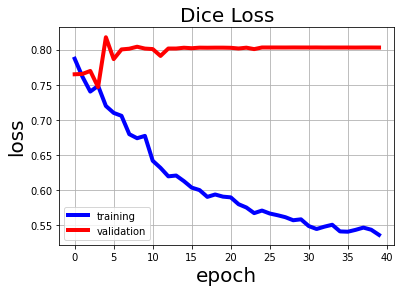

In [ ]:
# plot loss
plot_losses = np.array(plot_losses)
plt.plot(plot_losses[:,0], plot_losses[:,1], color='b', linewidth=4)
plt.plot(plot_losses[:,0], plot_losses[:,2], color='r', linewidth=4)
plt.title('Dice Loss', fontsize=20)
plt.xlabel('epoch',fontsize=20)
plt.ylabel('loss',fontsize=20)
plt.grid()
plt.legend(['training', 'validation']) # using a named size
plt.show()

In [ ]:
model.load_state_dict(torch.load('/content/saved_models/unet_epoch_5_0.78650.pt'))

<All keys matched successfully>

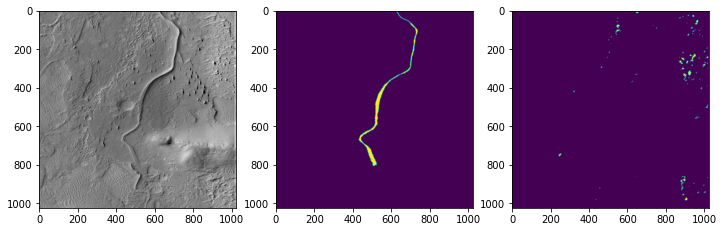

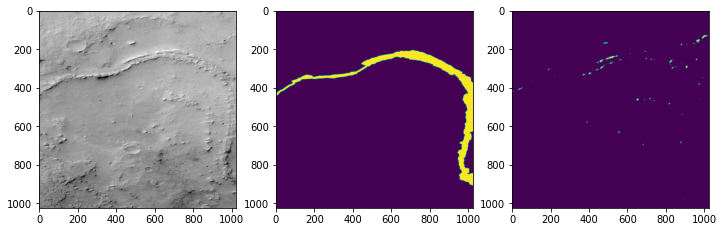

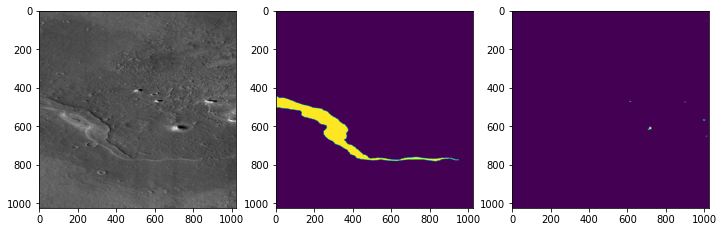

In [ ]:
model.eval()

for batch_i, (x, y) in enumerate(test_dataloader):
    for j in range(len(x)):
        result = model(x.to(device)[j:j+1])
        mask = torch.argmax(result, axis=1).cpu().detach().numpy()[0]
        im = np.moveaxis(x.to(device)[j].cpu().detach().numpy(), 0, -1).copy()*255
        im = im.astype(int)
        gt_mask = y[j]

        plt.figure(figsize=(12,12))

        plt.subplot(1,3,1)
        im = np.moveaxis(x.to(device)[j].cpu().detach().numpy(), 0, -1).copy()*255
        im = im.astype(int)
        plt.imshow(im)

        plt.subplot(1,3,2)
        plt.imshow(gt_mask)

        plt.subplot(1,3,3)
        plt.imshow(mask)
        plt.show()

In [ ]:
a = torch.randn(1, 2, 3, 3)
a

In [ ]:
a.view(-1)

In [ ]:
model.state_dict()